<a href="https://colab.research.google.com/github/sherry-ml/EVA7/blob/main/Step_1_1_Further_Reduce_Parameters_Session_5_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###1) Target:

We further want to reduce the number of parameters.

###2) Results:
Number of Parameters: 5,544 (previous 9380)

Best Train Accuracy: 98.34 (previous 98.59)

Best Test Accuracy:98.46 (previous 98.67)

###3) Analysis:
We have further reduced the number of parameters by approx 41%

Both Test and Train accuracy has gone down slightly. Considering the number of parameters we got rid of, this minimal drop doesnt seems to be of much concern at this point of time.

Next we will introduce Batch Normalization and see if it improves the performance.

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


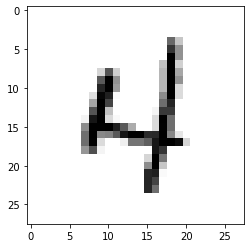

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

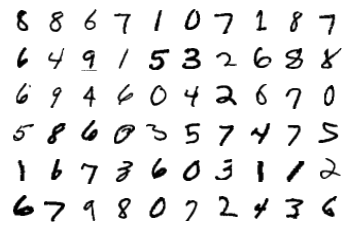

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [ ]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model
Let's start with the model we first saw

In [ ]:
class Net(nn.Module):
    def __init__(self):

      super().__init__()
      
      self.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, bias=False),
                                 nn.ReLU(inplace=True), #8*26*26
                                 nn.Conv2d(8, 16, 3, bias=False),
                                 nn.ReLU(inplace=True) #16*24*24
      )

      self.trans = nn.Sequential(nn.MaxPool2d(2,2), #16*12*12
                                 nn.Conv2d(16,8,1, bias=False),
                                 nn.ReLU(inplace=True) #8*12*12
                                 )

      self.conv2 = nn.Sequential(nn.Conv2d(8, 8, 3, bias=False),
                                 nn.ReLU(inplace=True), #8*10*10
                                 nn.Conv2d(8, 16, 3, bias=False),
                                 nn.ReLU(inplace=True), #16*8*8
                                 nn.Conv2d(16, 16, 3, bias=False),#16*6*6
                                 nn.ReLU(inplace=True)
                                 )

      self.output = nn.Sequential(nn.Conv2d(16, 10, 1, bias=False)) #10*6*6
      self.avgpool2d = nn.AvgPool2d(kernel_size=6) #10*1*1


    def forward(self, x):
        x = self.conv1(x)
        x = self.trans(x)
        x = self.conv2(x)
        x = self.output(x)
        x = self.avgpool2d(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
         MaxPool2d-5           [-1, 16, 12, 12]               0
            Conv2d-6            [-1, 8, 12, 12]             128
              ReLU-7            [-1, 8, 12, 12]               0
            Conv2d-8            [-1, 8, 10, 10]             576
              ReLU-9            [-1, 8, 10, 10]               0
           Conv2d-10             [-1, 16, 8, 8]           1,152
             ReLU-11             [-1, 16, 8, 8]               0
           Conv2d-12             [-1, 16, 6, 6]           2,304
             ReLU-13             [-1, 16, 6, 6]               0
           Conv2d-14             [

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing
 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=2.3025968074798584 Batch_id=468 Accuracy=9.86: 100%|██████████| 469/469 [00:10<00:00, 43.01it/s]



Test set: Average loss: 2.3025, Accuracy: 959/10000 (9.59%)

EPOCH: 1


Loss=2.3023927211761475 Batch_id=468 Accuracy=9.94: 100%|██████████| 469/469 [00:10<00:00, 42.92it/s]



Test set: Average loss: 2.3024, Accuracy: 1287/10000 (12.87%)

EPOCH: 2


Loss=2.295924663543701 Batch_id=468 Accuracy=12.69: 100%|██████████| 469/469 [00:10<00:00, 43.87it/s]



Test set: Average loss: 2.2969, Accuracy: 1135/10000 (11.35%)

EPOCH: 3


Loss=0.3812001645565033 Batch_id=468 Accuracy=57.10: 100%|██████████| 469/469 [00:10<00:00, 43.12it/s]



Test set: Average loss: 0.2455, Accuracy: 9251/10000 (92.51%)

EPOCH: 4


Loss=0.0758974552154541 Batch_id=468 Accuracy=92.73: 100%|██████████| 469/469 [00:11<00:00, 42.54it/s]



Test set: Average loss: 0.1313, Accuracy: 9614/10000 (96.14%)

EPOCH: 5


Loss=0.27257487177848816 Batch_id=468 Accuracy=95.42: 100%|██████████| 469/469 [00:11<00:00, 42.38it/s]



Test set: Average loss: 0.1310, Accuracy: 9601/10000 (96.01%)

EPOCH: 6


Loss=0.07794205844402313 Batch_id=468 Accuracy=96.36: 100%|██████████| 469/469 [00:10<00:00, 43.06it/s]



Test set: Average loss: 0.0811, Accuracy: 9750/10000 (97.50%)

EPOCH: 7


Loss=0.09637098759412766 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:11<00:00, 42.18it/s]



Test set: Average loss: 0.0784, Accuracy: 9757/10000 (97.57%)

EPOCH: 8


Loss=0.10844448953866959 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:10<00:00, 42.98it/s]



Test set: Average loss: 0.0770, Accuracy: 9761/10000 (97.61%)

EPOCH: 9


Loss=0.06295972317457199 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:10<00:00, 42.70it/s]



Test set: Average loss: 0.0700, Accuracy: 9789/10000 (97.89%)

EPOCH: 10


Loss=0.14551480114459991 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:10<00:00, 42.70it/s]



Test set: Average loss: 0.0614, Accuracy: 9804/10000 (98.04%)

EPOCH: 11


Loss=0.03551753982901573 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:11<00:00, 42.35it/s]



Test set: Average loss: 0.0538, Accuracy: 9846/10000 (98.46%)

EPOCH: 12


Loss=0.013764818198978901 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:11<00:00, 41.67it/s]



Test set: Average loss: 0.0551, Accuracy: 9821/10000 (98.21%)

EPOCH: 13


Loss=0.04359791800379753 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:11<00:00, 41.32it/s]



Test set: Average loss: 0.0569, Accuracy: 9821/10000 (98.21%)

EPOCH: 14


Loss=0.041833385825157166 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:11<00:00, 42.25it/s]



Test set: Average loss: 0.0586, Accuracy: 9819/10000 (98.19%)



Text(0.5, 1.0, 'Test Accuracy')

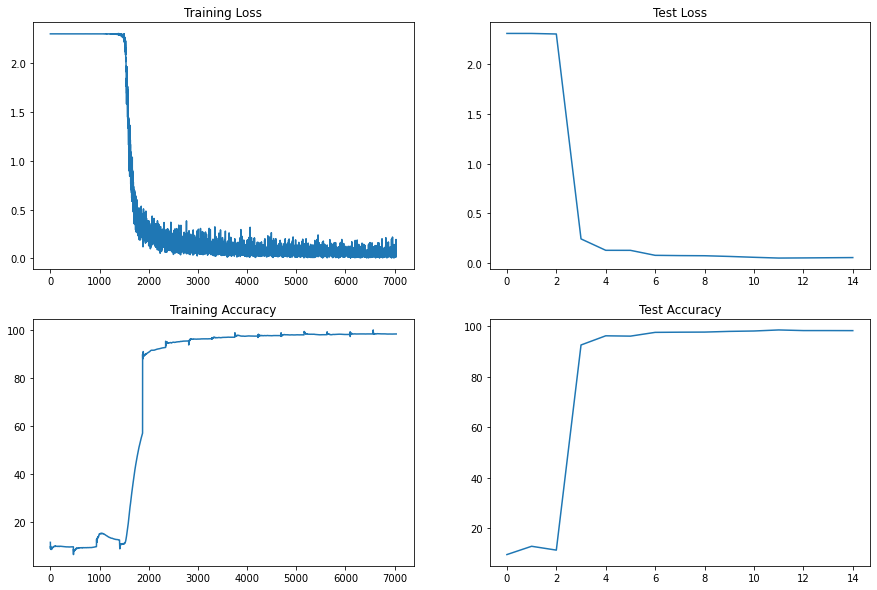

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")